In [1]:
import pandas as pd
import re 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import locale
from locale import atof
import seaborn as sns
import gmaps
import gmaps.datasets
import os
gmaps.configure(api_key=os.environ["GOOGLE_API_KEY"])
from scipy.stats import chi2
from scipy.stats import chisquare

In [2]:
sns.set_palette('deep',desat = .6)
sns.set_context(rc = {'figure.figsize':(8,4)})

In [3]:
crime = pd.read_csv('BostonCrime/crime.csv')

Number of bins for a longitude/latitude grid across the city:

In [4]:
numbins = 50

In [5]:
crime.shape

(195622, 17)

In [6]:
pd.set_option('display.max_rows',20)

In [7]:
crime

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I172047308,3006,Medical Assistance,SICK/INJURED/MEDICAL - PERSON,D4,130,NaN,2017-06-13 21:55:00,2017,6,Tuesday,21,Part Three,HUNTINGTON AVE,42.348577,-71.077720,"(42.34857652, -71.07772012)"
1,I172047296,802,Simple Assault,ASSAULT SIMPLE - BATTERY,B2,326,NaN,2017-06-13 20:53:00,2017,6,Tuesday,20,Part Two,QUINCY ST,42.313322,-71.075915,"(42.31332153, -71.07591511)"
2,I172047293,802,Simple Assault,ASSAULT SIMPLE - BATTERY,B2,331,NaN,2017-06-13 21:01:00,2017,6,Tuesday,21,Part Two,BAKER AVE,42.312387,-71.070862,"(42.31238668, -71.07086154)"
3,I172047291,706,Auto Theft,AUTO THEFT - MOTORCYCLE / SCOOTER,A1,67,NaN,2017-06-06 09:00:00,2017,6,Tuesday,9,Part One,ANDERSON ST,42.360306,-71.067789,"(42.36030562, -71.06778870)"
4,I172047289,3301,Verbal Disputes,VERBAL DISPUTE,E18,516,NaN,2017-06-13 21:01:00,2017,6,Tuesday,21,Part Three,TRUMAN PKWY,42.251278,-71.120194,"(42.25127804, -71.12019402)"
5,I172047288,3114,Investigate Property,INVESTIGATE PROPERTY,NaN,,NaN,2017-06-13 21:33:00,2017,6,Tuesday,21,Part Three,NaN,42.308064,-71.065067,"(42.30806374, -71.06506719)"
6,I172047287,2629,Harassment,HARASSMENT,B2,324,NaN,2017-06-13 21:42:00,2017,6,Tuesday,21,Part Two,DANUBE ST,42.317439,-71.075478,"(42.31743922, -71.07547845)"
7,I172047286,1830,Drug Violation,DRUGS - SICK ASSIST - HEROIN,D4,,NaN,2017-06-13 21:12:00,2017,6,Tuesday,21,Part Two,NaN,42.344316,-71.074464,"(42.34431640, -71.07446411)"
8,I172047283,3831,Motor Vehicle Accident Response,M/V - LEAVING SCENE - PROPERTY DAMAGE,C11,235,NaN,2017-05-28 09:00:00,2017,5,Sunday,9,Part Three,BUTTONWOOD ST,42.320878,-71.055852,"(42.32087815, -71.05585215)"
9,I172047282,3115,Investigate Person,INVESTIGATE PERSON,NaN,,NaN,2017-06-13 20:45:00,2017,6,Tuesday,20,Part Three,NaN,42.335066,-71.078791,"(42.33506554, -71.07879088)"


# Create a dataframe with only records that have correct geographic coordinates

In [8]:
bad_coords = ((crime['Lat'] < 42)|np.isnan(crime['Lat'])|(crime['Lat'] > 43)|(crime['Long'] < -72)|(crime['Long'] > -70)|np.isnan(crime['Long']))
#print sum(wrong_or_nanlats)
crime_goodcoords = crime[np.invert(bad_coords)]

In [9]:
crime_goodcoords.shape

(183800, 17)

In [74]:
good_coord_offence_types = set(crime_goodcoords.OFFENSE_CODE_GROUP)
good_coord_offence_types = list(good_coord_offence_types)

# Create a scatter plot of all crime across the city

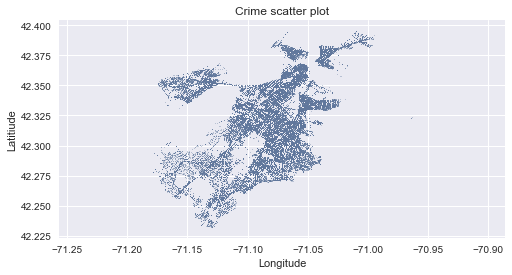

In [10]:
#%matplotlib inline
plt.scatter(x = crime_goodcoords.Long,y = crime_goodcoords.Lat, s= 0.1)
plt.xlabel('Longitude')
plt.ylabel('Latitiude')
plt.title('Crime scatter plot')
plt.axis('equal')
plt.show()

In [11]:
plt.close()

# Overlayed scatter plots of different crimes

In [12]:
# This was not particularly useful because the plots are too dense and too overlapping.
'''colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
mycolors = map(str,colors.keys())

grouped_cg = crime_goodcoords.groupby('OFFENSE_CODE_GROUP') 
i = 0
for crime_type,group in grouped_cg:
    plt.scatter(x = crime_goodcoords.Long,y = crime_goodcoords.Lat, s= 0.5,c = mycolors[i])
    i += 1
plt.xlabel('Longitude')
plt.ylabel('Latitiude')
plt.title('Crime scatter plot')
plt.show()'''

"colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)\nmycolors = map(str,colors.keys())\n\ngrouped_cg = crime_goodcoords.groupby('OFFENSE_CODE_GROUP') \ni = 0\nfor crime_type,group in grouped_cg:\n    plt.scatter(x = crime_goodcoords.Long,y = crime_goodcoords.Lat, s= 0.5,c = mycolors[i])\n    i += 1\nplt.xlabel('Longitude')\nplt.ylabel('Latitiude')\nplt.title('Crime scatter plot')\nplt.show()"

# 2D histogram of all crimes by coordinates

In [12]:
#%matplotlib inline
hist_all, x_edges, y_edges = np.histogram2d(crime_goodcoords.Long,crime_goodcoords.Lat,bins = numbins)
hist_all = hist_all.T
X, Y = np.meshgrid(x_edges,y_edges)
plt.pcolormesh(X, Y, hist_all,cmap = 'jet')
plt.xlabel('Long')
plt.ylabel('Lat')
plt.axis('equal')

(-71.178673779999997,
 -70.963676149999998,
 42.232413299999997,
 42.395041579999997)

# 2D histogram of crimes give type and day of the week by coordinates

In [14]:
#%matplotlib inline
offence_code_group = 'Larceny'
day_of_week = 'Saturday'
mask = ((crime_goodcoords.DAY_OF_WEEK == day_of_week) & (crime_goodcoords.OFFENSE_CODE_GROUP == offence_code_group))
this_crime = crime_goodcoords[mask]
hist_cd, x_edges, y_edges = np.histogram2d(this_crime.Long,this_crime.Lat,bins = [x_edges, y_edges])
hist_cd = hist_cd.T
X, Y = np.meshgrid(x_edges,y_edges)
plt.pcolormesh(X, Y, hist_cd,cmap = 'jet')
plt.xlabel('Long')
plt.ylabel('Lat')
plt.axis('equal')

(-71.178673779999997,
 -70.963676149999998,
 42.232413299999997,
 42.395041579999997)

# Heatmap of crime by day of the week on google maps

In [15]:
'''offence_code_group = 'Aggravated Assault'
day_of_week = 'Sunday'
mask = ((crime_goodcoords.DAY_OF_WEEK == day_of_week) & (crime_goodcoords.OFFENSE_CODE_GROUP == offence_code_group))
this_crime = crime_goodcoords[mask]

MyLocs = []
for ind in this_crime.index:
    this_loc = (this_crime.Lat[ind],this_crime.Long[ind])
    MyLocs.append(this_loc) 


fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(MyLocs))
fig
'''

"offence_code_group = 'Aggravated Assault'\nday_of_week = 'Sunday'\nmask = ((crime_goodcoords.DAY_OF_WEEK == day_of_week) & (crime_goodcoords.OFFENSE_CODE_GROUP == offence_code_group))\nthis_crime = crime_goodcoords[mask]\n\nMyLocs = []\nfor ind in this_crime.index:\n    this_loc = (this_crime.Lat[ind],this_crime.Long[ind])\n    MyLocs.append(this_loc) \n\n\nfig = gmaps.figure()\nfig.add_layer(gmaps.heatmap_layer(MyLocs))\nfig\n"

## Write a function that takes offence type and day of the week as input and creates a heatmap on google maps:

In [16]:
def offence_heat_map(offence_code_group,day_of_week):
    mask = ((crime_goodcoords.DAY_OF_WEEK == day_of_week) & (crime_goodcoords.OFFENSE_CODE_GROUP == offence_code_group))
    this_crime = crime_goodcoords[mask]
    
    MyLocs = []
    for ind in this_crime.index:
        this_loc = (this_crime.Lat[ind],this_crime.Long[ind])
        print this_loc
        MyLocs.append(this_loc) 
    

    fig = gmaps.figure()
    fig.add_layer(gmaps.heatmap_layer(MyLocs))
    fig
    return fig

In [ ]:
fig1 = offence_heat_map('Robbery','Sunday') # Suppressed output on this line

In [18]:
fig1

Widget Javascript not detected.  It may not be installed or enabled properly.


# Group crimes by offence code group for analysis

In [19]:
grouped_crimes = crime.groupby('OFFENSE_CODE_GROUP')

In [20]:
# t = (pd.DataFrame(group.DAY_OF_WEEK.value_counts()) for crime_type,group in grouped_crimes)

## For each offence code group get the counts by the number of days:

In [21]:
daycount_by_crime_type = pd.DataFrame()
for crime_type,group in grouped_crimes:
    day_count = group.DAY_OF_WEEK.value_counts()
    these_weekdays = map(str,day_count.index.values)
    day_count_array = day_count.values
    this_df = pd.DataFrame(data = day_count_array.reshape(1,len(day_count_array)),index = [crime_type],columns = these_weekdays)
    daycount_by_crime_type = pd.concat([daycount_by_crime_type,this_df],axis = 0)
    #print type(group)
    #print crime_type
    #days.index.values = crime_type
    #daycount_by_crime_type = daycount_by_crime_type.append(days) 
    

Re-order the columns to weekdays:

In [22]:
weekdays = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']

In [23]:
daycount_by_crime_type = daycount_by_crime_type[weekdays]

Replace NaN values with 0's:

In [24]:
daycount_by_crime_type.replace(np.NaN,0,inplace = True)

## Bar plot of crime incidence by day of the week for a given offence group:

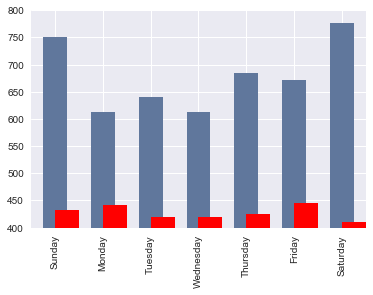

In [56]:
crime1 = 'Aggravated Assault'
crime2 = 'Auto Theft'
x_axis1 = map(float,range(7))
x_axis2 = map(lambda x: x +0.25,x_axis1)
incidence_by_day1 = daycount_by_crime_type.ix[crime1,:]
incidence_by_day2 = daycount_by_crime_type.ix[crime2,:]
fig, ax = plt.subplots()
plt.subplot(111)
plt.bar(x_axis1,incidence_by_day1.values,width = 0.5)
plt.bar(x_axis2,incidence_by_day2.values,color = 'red',width = 0.5)
plt.xticks(x_axis1, weekdays,rotation = 'vertical')
plt.ylim((400,800))
plt.xlim((-0.5,6.5))
plt.show()

In [26]:
incidence_by_day1.values

array([ 750.,  613.,  640.,  612.,  685.,  671.,  776.])

In [27]:
x_axis1

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

In [28]:
daycount_by_crime_type

,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
Aggravated Assault,750.0,613.0,640.0,612.0,685.0,671.0,776.0
Aircraft,3.0,0.0,4.0,3.0,2.0,2.0,3.0
Arson,9.0,7.0,6.0,7.0,14.0,3.0,12.0
Assembly or Gathering Violations,148.0,69.0,42.0,48.0,42.0,105.0,224.0
Auto Theft,433.0,441.0,419.0,420.0,426.0,446.0,411.0
Auto Theft Recovery,74.0,84.0,86.0,101.0,99.0,91.0,77.0
Ballistics,98.0,84.0,86.0,70.0,78.0,81.0,114.0
Bomb Hoax,2.0,12.0,10.0,8.0,12.0,14.0,5.0
Burglary - No Property Taken,0.0,1.0,1.0,0.0,0.0,0.0,0.0
Commercial Burglary,124.0,132.0,136.0,123.0,100.0,124.0,131.0


In [29]:
daycount_by_crime_type.index.values

array(['Aggravated Assault', 'Aircraft', 'Arson',
       'Assembly or Gathering Violations', 'Auto Theft',
       'Auto Theft Recovery', 'Ballistics', 'Bomb Hoax',
       'Burglary - No Property Taken', 'Commercial Burglary',
       'Confidence Games', 'Counterfeiting', 'Criminal Harassment',
       'Disorderly Conduct', 'Drug Violation', 'Embezzlement',
       'Evading Fare', 'Explosives', 'Fire Related Reports',
       'Firearm Discovery', 'Firearm Violations', 'Fraud', 'Gambling',
       'HOME INVASION', 'HUMAN TRAFFICKING',
       'HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE', 'Harassment',
       'Harbor Related Incidents', 'Homicide', 'Indecent Assault',
       'Investigate Person', 'Investigate Property',
       'Landlord/Tenant Disputes', 'Larceny', 'Larceny From Motor Vehicle',
       'License Plate Related Incidents', 'License Violation',
       'Liquor Violation', 'Manslaughter', 'Medical Assistance',
       'Missing Person Located', 'Missing Person Reported',
       'Motor Ve

## Calculate the chi-square statistic for daycount_by_crime_type:

Calculte total incidents by crime group and store in a new dataframe:

In [30]:
daycount_contingency = daycount_by_crime_type.copy()
daycount_contingency['Total'] = daycount_by_crime_type.sum(axis = 1)

Keep only crime types with high frequency to calculate a valid chi-square statistic:

In [31]:
mask = daycount_contingency['Total'] > 200
daycount_contingency_high = daycount_contingency[mask]

Expected values per day (assuming equal likelihood for each crime by day of the week):

In [32]:
expected_per_day = daycount_contingency_high['Total']/7
expected_per_day_rep = np.matlib.repmat(expected_per_day,7,1).T

## Evaluate the chi_square cdf for the entire table:

In [33]:
daycount_contingency_high = daycount_contingency_high.drop('Total',axis = 1)
chi_sq_all = ((daycount_contingency_high-expected_per_day_rep)**2)/expected_per_day_rep

In [34]:
chi_sq = chi_sq_all.sum(axis = 0).sum()
df = chi_sq_all.shape[0]*(chi_sq_all.shape[1]-1)
chi2.cdf(chi_sq,df)

1.0

## Evaluate chi-square probability for each crime:

In [35]:
high_freq_crimes = daycount_contingency_high.index.values
Chisq_pvals = pd.Series(index = high_freq_crimes)
for crime_cat in high_freq_crimes:
    x,pval = chisquare(daycount_contingency_high.ix[crime_cat,:])
    Chisq_pvals[crime_cat] = pval

Crimes were we could not reject the null hypothesis that frequency is equal for all days of the week:

In [36]:
Chisq_pvals[Chisq_pvals>0.05]

Auto Theft                         0.897005
Auto Theft Recovery                0.298488
Commercial Burglary                0.348919
Evading Fare                       0.161010
Fire Related Reports               0.677822
Indecent Assault                   0.357677
Landlord/Tenant Disputes           0.372133
License Plate Related Incidents    0.198753
Offenses Against Child / Family    0.963676
Other Burglary                     0.054581
Property Found                     0.573039
Property Related Damage            0.437518
Restraining Order Violations       0.410786
Robbery                            0.060107
Verbal Disputes                    0.115522
dtype: float64

In [37]:
Chisq_pvals[Chisq_pvals<0.05]

Aggravated Assault                   1.984159e-06
Assembly or Gathering Violations     1.538282e-59
Ballistics                           2.454613e-02
Confidence Games                     1.453345e-13
Counterfeiting                       1.382281e-08
Disorderly Conduct                   1.618123e-02
Drug Violation                      6.244796e-124
Firearm Discovery                    1.909081e-02
Firearm Violations                   6.173896e-06
Fraud                                8.802437e-55
                                        ...      
Property Lost                        7.727684e-09
Recovered Stolen Property            5.355879e-03
Residential Burglary                 2.011935e-10
Search Warrants                      9.033111e-22
Sex Offender Registration            1.572768e-24
Simple Assault                       4.468926e-08
Towed                                1.010318e-06
Vandalism                            1.593437e-10
Violations                           7.092135e-09


# Is there a relationship between the location of crimes and the location of street lights?

## Load the street light data:

In [14]:
lights = pd.read_csv('BostonCrime/streetlights.csv')

## Scatter plot of street lights:

There are no nans in this data:

In [15]:
sum(np.isnan(lights['Long'])|np.isnan(lights['Lat']))

0

Overlay lights and crime:

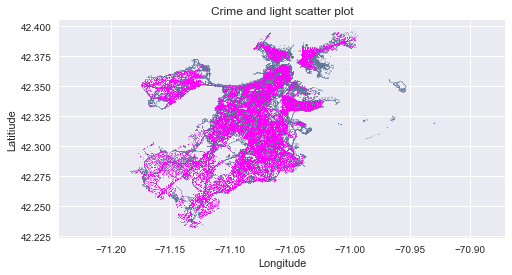

In [40]:
#%matplotlib inline
plt.scatter(x = lights.Long,y = lights.Lat, s= 0.1)
plt.scatter(x = crime_goodcoords.Long,y = crime_goodcoords.Lat, s= 0.1,color = 'magenta')

plt.xlabel('Longitude')
plt.ylabel('Latitiude')
plt.title('Crime and light scatter plot')
plt.axis('equal')
plt.show()



## 2D histogram of lights across the city:

In [16]:
#%matplotlib inline
histlight, x_edges1, y_edges1 = np.histogram2d(lights.Long,lights.Lat,bins = [x_edges, y_edges])#bins = [x_edges, y_edges]
histlight = histlight.T
X, Y = np.meshgrid(x_edges1,y_edges1)
plt.pcolormesh(X, Y, histlight,cmap = 'jet')
plt.xlabel('Long')
plt.ylabel('Lat')
plt.axis('equal')

(-71.178673779999997,
 -70.963676149999998,
 42.232413299999997,
 42.395041579999997)

### A smoothed heat map:

In [42]:
#%matplotlib inline
plt.axis('equal')
plt.imshow(histlight, cmap = 'jet',origin = "lower", interpolation = "gaussian")

### SNS can create a prettier heat map but it takes a little while to run:

In [43]:
'''data = np.asarray([lights.Long,lights.Lat]).T
f, ax = plt.subplots(figsize=(7, 7))
sns.kdeplot(data, shade=True, ax=ax)'''

'data = np.asarray([lights.Long,lights.Lat]).T\nf, ax = plt.subplots(figsize=(7, 7))\nsns.kdeplot(data, shade=True, ax=ax)'

### Create a 3D barplot of streetlights. 

#### Color bars with less than one light as blue

In [17]:
plt.close()
%matplotlib 

fig_bars = plt.figure()
ax = fig_bars.add_subplot(111, projection='3d')
xpos1, ypos1 = np.meshgrid(x_edges1[:-1], y_edges1[:-1])
xpos1 = xpos1.flatten('F')
ypos1 = ypos1.flatten('F')
zpos1 = np.zeros_like(xpos1)

# Construct arrays with the dimensions for the 16 bars.
dx = 0.0025 * np.ones_like(zpos1)
dy = dx.copy()
dz = histlight.flatten('F')

# Color bars with less than one light as blue:

barcolors = ['b']*(dz.shape[0])
type(barcolors)
len(barcolors)
mask = dz >= 1
ind = np.arange(len(barcolors))
redind = ind[mask]
for i in redind:
    barcolors[i] = 'r'


ax.bar3d(xpos1, ypos1, zpos1, dx, dy, dz, color=barcolors, zsort='average')
#plt.show()

Using matplotlib backend: Qt5Agg


In [18]:
plt.close()

# Does crime depend on time of the day? Do specific crimes depend on time of the day?

## The first thing we can look at is if there is a significant correlation 

# Do any crimes have a relationship with street-light concentration? Do crimes that are more likely to happen in the evening have a relationship with street light concentration?

## All offence types versus street lights:

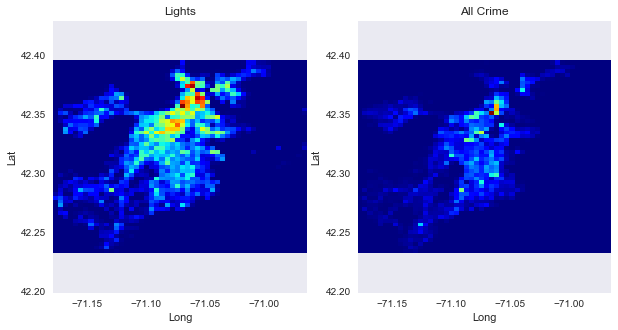

In [19]:
%matplotlib inline
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.pcolormesh(X, Y, histlight,cmap = 'jet')
plt.xlabel('Long')
plt.ylabel('Lat')
plt.axis('equal')
plt.title('Lights')

plt.subplot(122)
plt.pcolormesh(X, Y, hist_all,cmap = 'jet')
plt.xlabel('Long')
plt.ylabel('Lat')
plt.axis('equal')
plt.title('All Crime')


### Pearson correlation:

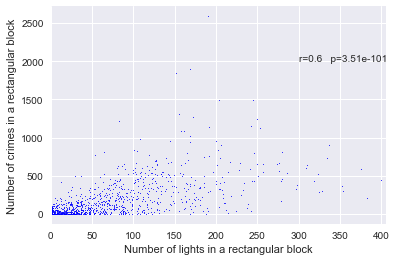

In [166]:
# Flatten the hist arrays:
histlight_row = histlight.flatten('F')
hist_all_row = hist_all.flatten('F')

# We need to include only rectangular bins that are within the city boundaries. 
# A hand-wavy way to do this is to only keep those bins that have more than one 
# street light:
mask_nonzerolights = histlight_row > 0
x_light = histlight_row[mask_nonzerolights]
y_crime = hist_all_row[mask_nonzerolights]

# Calculate Pearson correlation:
from scipy.stats.stats import pearsonr
r,p= pearsonr(x_light,y_crime)


# Plot the flattened histogram counts:
fig2,ax2 = plt.subplots()
ax2.plot(x_light,y_crime,'bo',markersize = 1)
ax2.set_xlabel('Number of lights in a rectangular block')
ax2.set_ylabel('Number of crimes in a rectangular block')
ax2.set_xlim(0,405)
pstr = '%s' % float('%.3g' % p)
rstr = '%s' % float('%.3g' % r)
txt2 = 'r='+rstr+'   p='+pstr
ax2.text(300, 2000, txt2)

## Offence by type and street light concentration:

In [168]:
def pearson_w_lights(offence_code_group):
    mask = crime_goodcoords.OFFENSE_CODE_GROUP == offence_code_group
    this_crime = crime_goodcoords[mask]
    this_crime_hist, x_edges1, y_edges1 = np.histogram2d(this_crime.Long,this_crime.Lat,bins = [x_edges, y_edges])
    this_crime_hist = this_crime_hist.T

    y_this_crime = this_crime_hist.flatten('F')
    y_this_crime = y_this_crime[mask_nonzerolights]
    
    r_pearson,p_pearson = pearsonr(x_light,y_this_crime)
    
    fign,axn = plt.subplots()
    axn.plot(x_light,y_this_crime,'bo',markersize = 1)
    axn.set_xlabel('Number of lights in a rectangular block')
    axn.set_ylabel('Number of crimes in a rectangular block')
    axn.set_title(offence_code_group)
    pstr = '%s' % float('%.3g' % p_pearson)
    rstr = '%s' % float('%.3g' % r_pearson)
    txtn = 'r='+rstr+'  p='+pstr
    axn.text(300,y_this_crime.max(), txtn)
    
    return r_pearson,p_pearson,y_this_crime,this_crime.shape[0]

'    else:\n        print offence_type,numincidents'

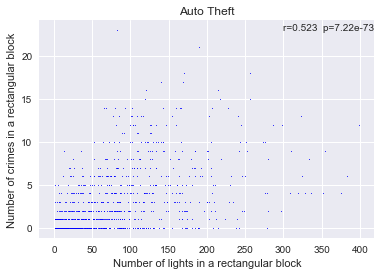

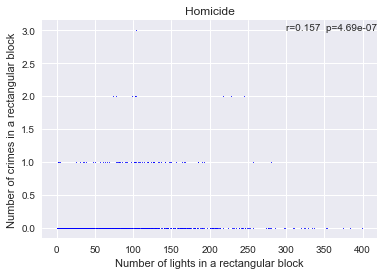

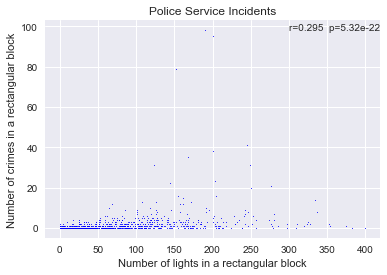

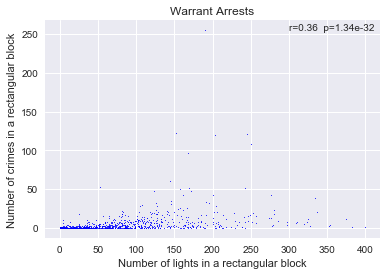

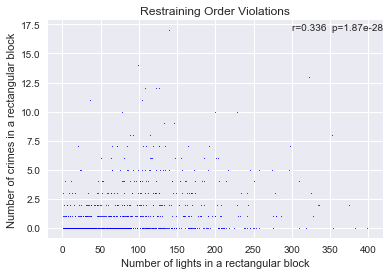

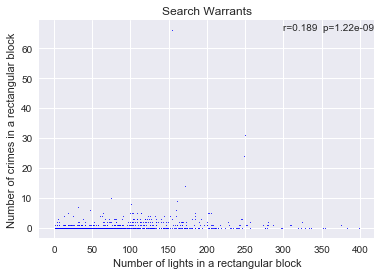

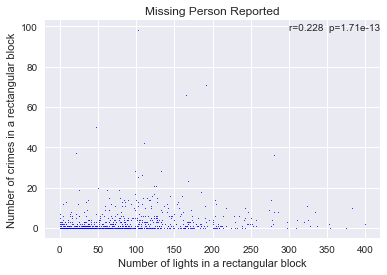

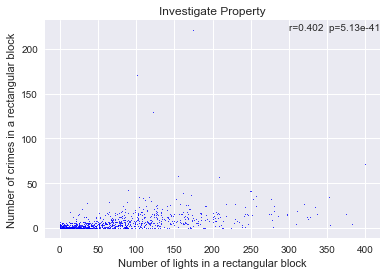

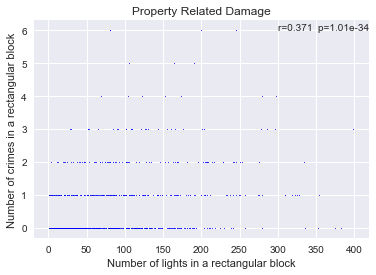

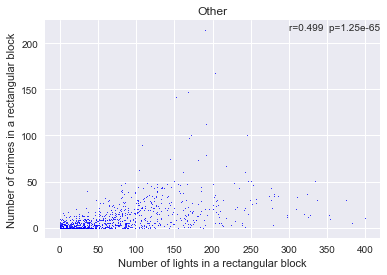

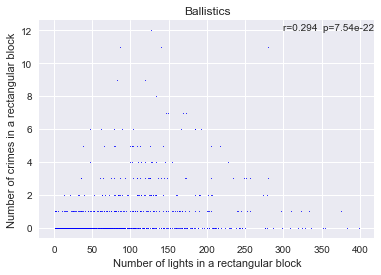

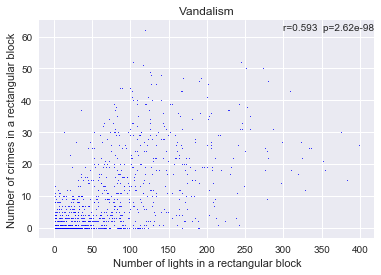

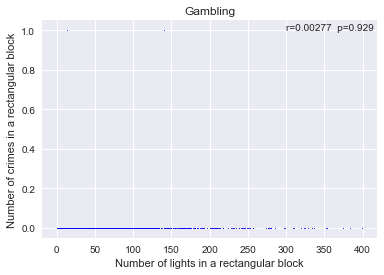

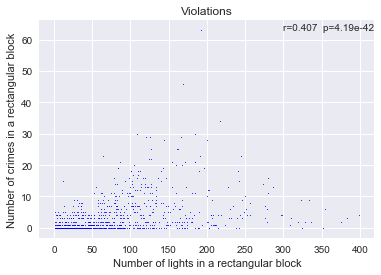

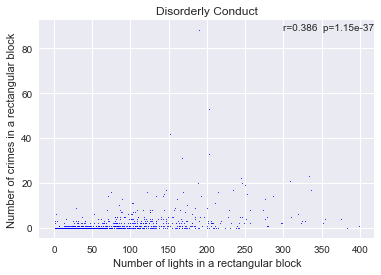

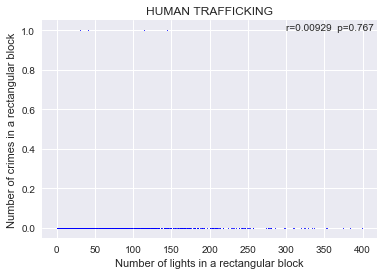

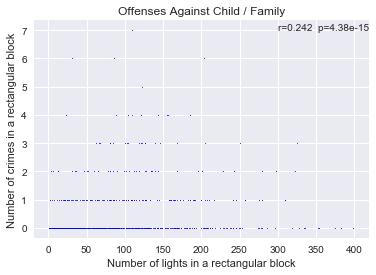

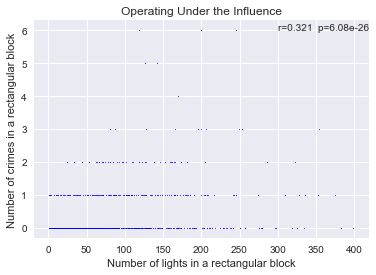

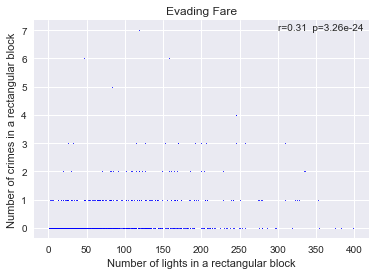

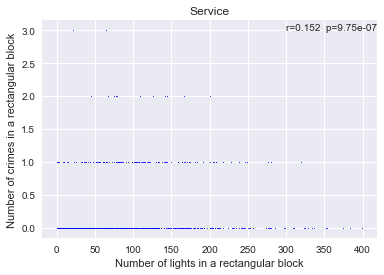

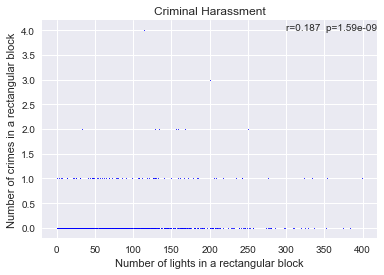

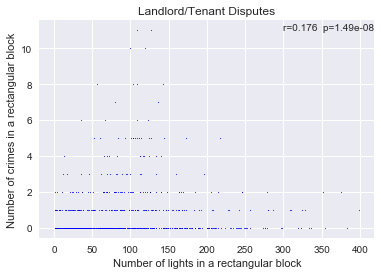

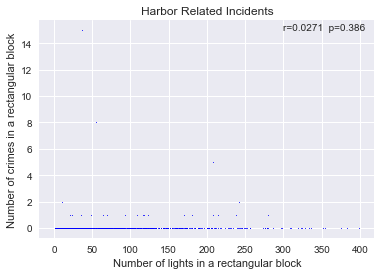

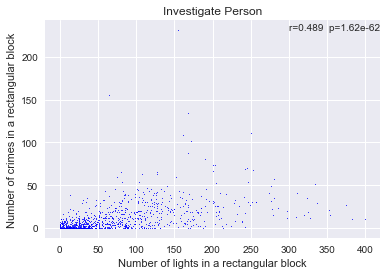

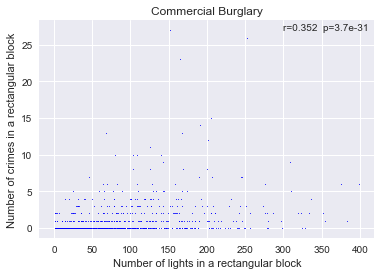

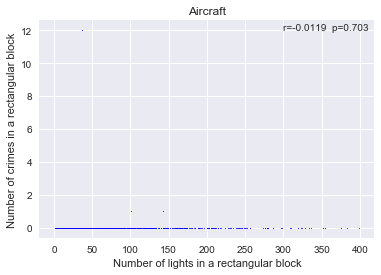

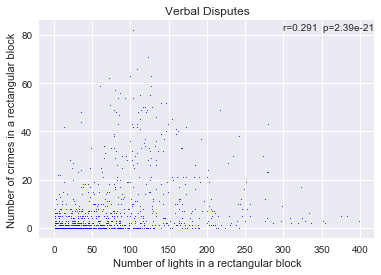

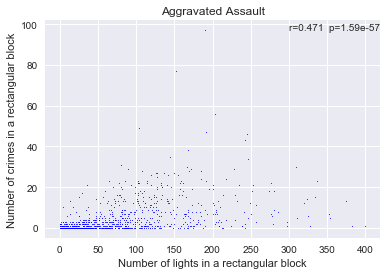

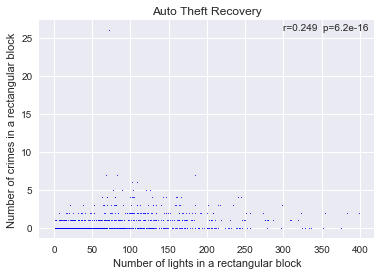

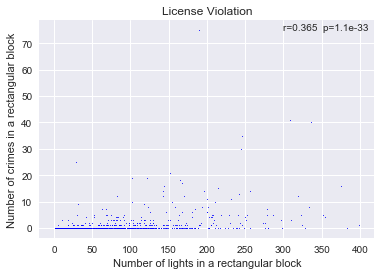

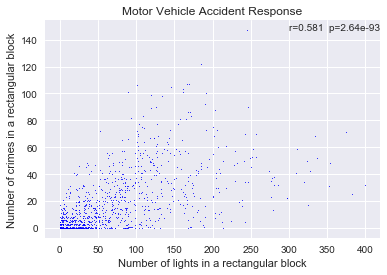

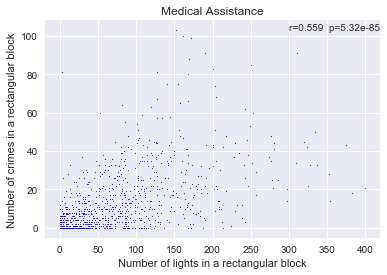

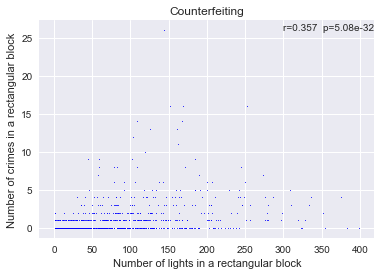

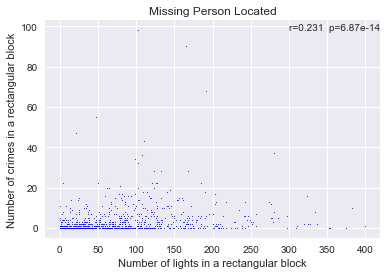

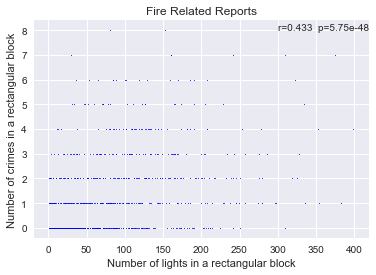

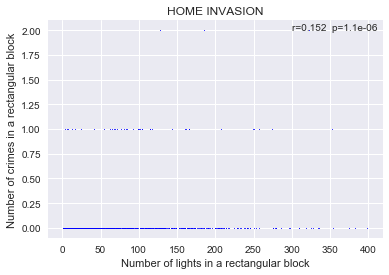

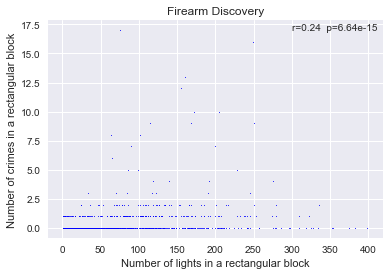

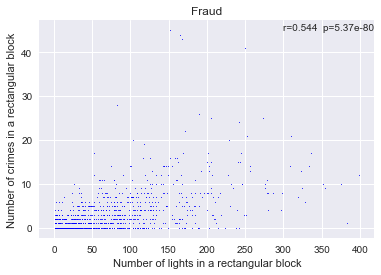

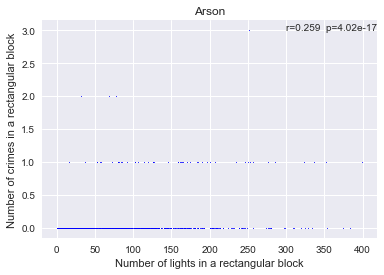

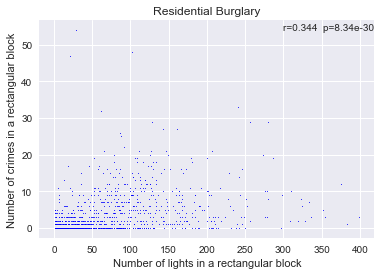

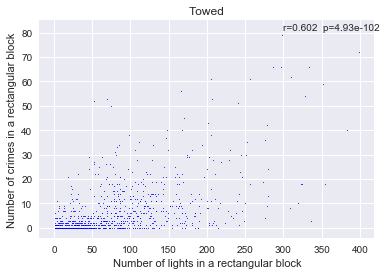

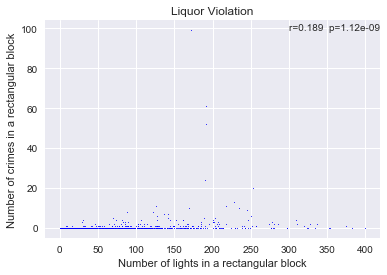

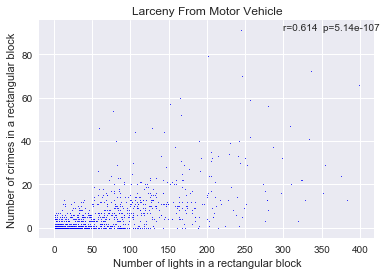

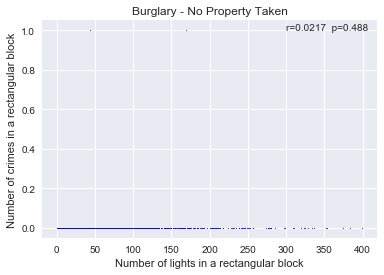

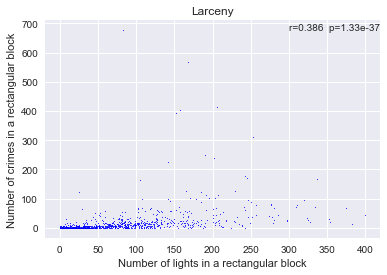

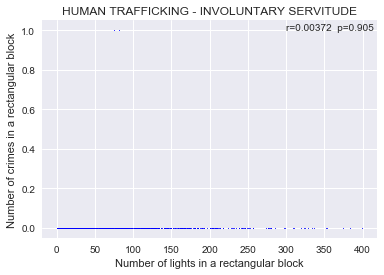

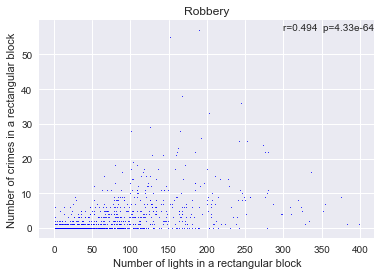

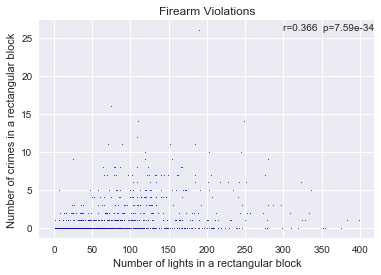

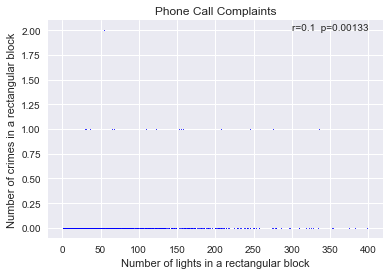

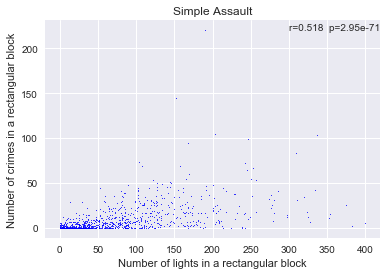

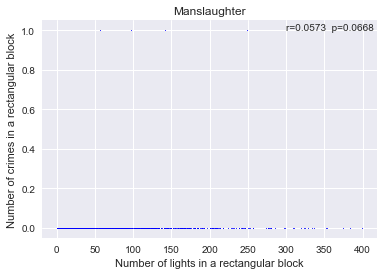

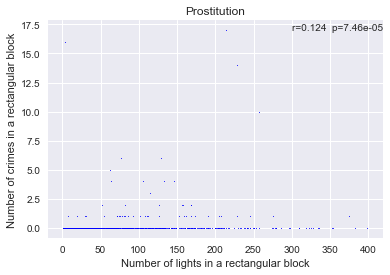

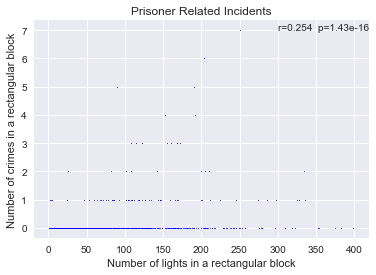

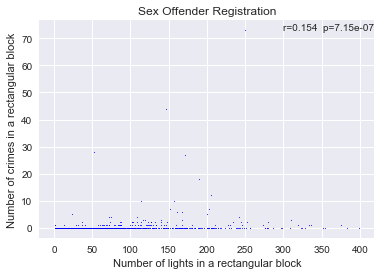

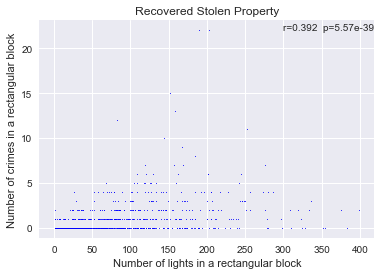

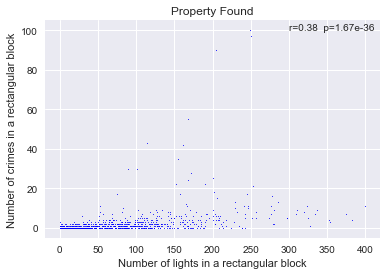

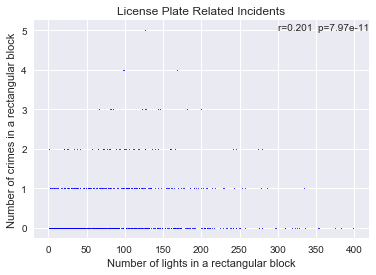

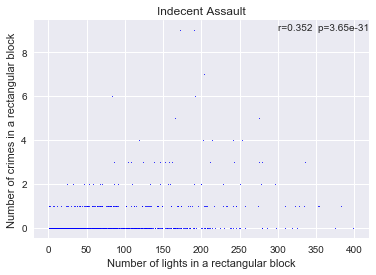

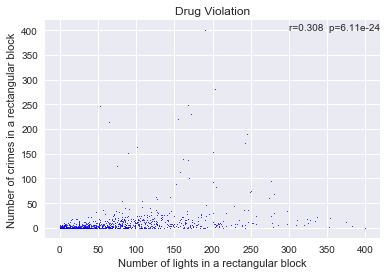

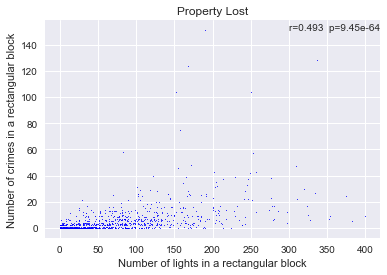

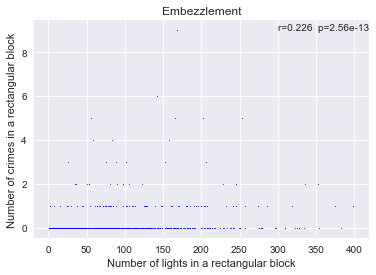

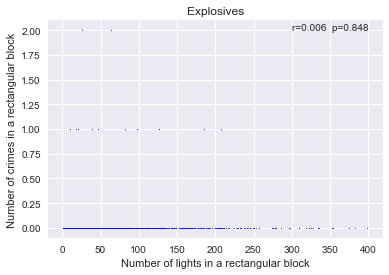

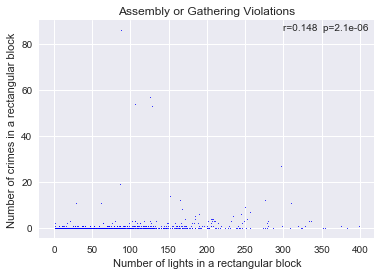

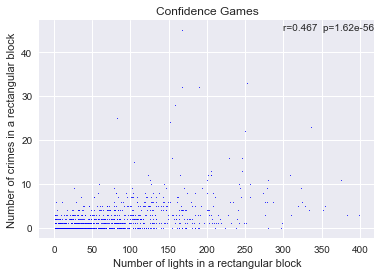

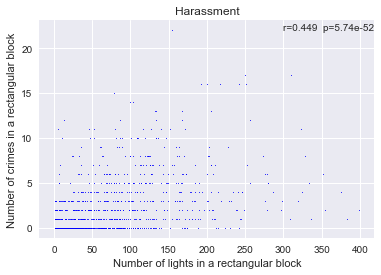

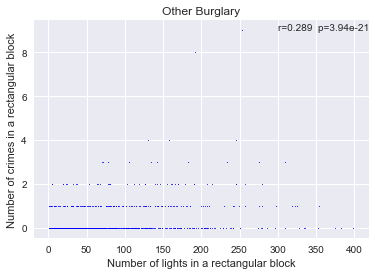

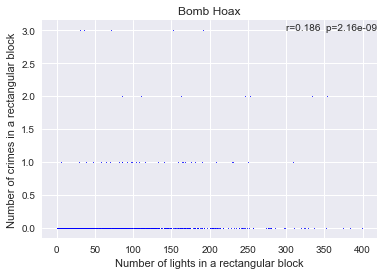

In [169]:
num_sig_cor = 0 # Number of offence types with significant correlelations 
for offence_type in good_coord_offence_types:
    r_pearson,p_pearson,y_this_crime,numincidents = pearson_w_lights(offence_type)
    if p_pearson < 0.05:
        num_sig_cor += 1
        #print offence_type,r_pearson,p_pearson
        
        if r_pearson <0: 
            print '***********'
'''    else:
        print offence_type,numincidents'''
            

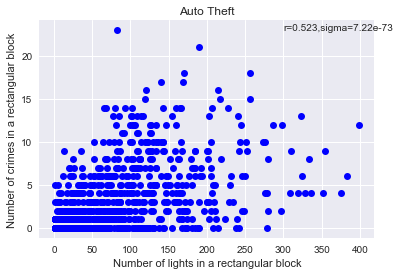

In [154]:
fign,axn = plt.subplots()
axn.plot(x_light,y_this_crime,'bo')
axn.set_xlabel('Number of lights in a rectangular block')
axn.set_ylabel('Number of crimes in a rectangular block')
axn.set_title(offence_code_group)
pstr = '%s' % float('%.3g' % p_pearson)
rstr = '%s' % float('%.3g' % r_pearson)
txtn = 'r='+rstr+',sigma='+pstr
axn.text(300,y_this_crime.max(), txtn)